In [113]:
import csv
import numpy as np
from matplotlib import pyplot
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint

from scipy.stats import gmean



In [3]:
from numpy import genfromtxt
my_data = genfromtxt('Data1.csv', delimiter=',')

my_data = my_data[1:]

In [4]:
def get_delta_rate(series):
    return np.array([(current-previous)/previous for previous,current in zip(series,series[1:])])

def geometric_mean(series):
    return gmean(1+series)-1

In [5]:
delta_stocks = get_delta_rate(my_data[0:,1])
delta_bounds = get_delta_rate(my_data[0:,2])
delta_mm = get_delta_rate(my_data[0:,3])

In [6]:
invest_matrix = np.array([delta_stocks, delta_bounds, delta_mm])
sigma = np.cov(invest_matrix)
sigma

array([[ 0.0284435 ,  0.00395798,  0.00021196],
       [ 0.00395798,  0.01138682, -0.00019987],
       [ 0.00021196, -0.00019987,  0.00118147]])

In [7]:
mu = np.array([geometric_mean(delta_stocks), geometric_mean(delta_bounds), geometric_mean(delta_mm)])
mu

array([0.1073211 , 0.07366871, 0.06270134])

In [127]:
R = 0

def setR(val):
    global R
    R = val
    
def getR():
    return R

def objetivo(x):
    return np.matmul(np.matmul(np.transpose(x), sigma), x)

def gradiente(x):
    return 2 + np.matmul(sigma, x)

def hessian(x):
    return 2 + sigma

def restriccion_1(x):
    return (mu[0]*x[0] + mu[1]*x[1]+ mu[2]*x[2] - getR())

def restriccion_2(x):
    return (x[0] + x[1] + x[2] - 1)

x0 = [0,0,0]

gradiente(x0)

array([2., 2., 2.])

In [128]:
def solve(method_name, restrictions, gradient, hessian):
    rec1 ={'type': 'ineq', 'fun': restriccion_1}
    rec2={'type': 'eq', 'fun': restriccion_2}

    restrs = [rec1, rec2]
    z_points = list()
    r_points = list()
    for i in range(1,11):
        setR(0.05 + 0.005*i)
        sol = minimize(objetivo, x0, method=method_name, constraints=restrictions, jac=gradiente, hess=hessian)
        z_points.append([sol.fun, R])
        r_points.append(R)
    #print(z_points)
    return np.array(z_points)

def graph(points):
    pyplot.plot(points[0:,0], points[0:,1], 'ro')
    pyplot.xlabel("Retorno", fontsize= 14)
    pyplot.ylabel("Riesgo", fontsize=14)
    pyplot.suptitle("Frontera Eficiente", fontsize=20)
    pyplot.show()

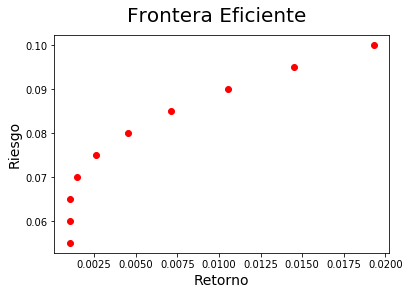

In [129]:
res = [{'type': 'ineq', 'fun': restriccion_1}, {'type': 'eq', 'fun': restriccion_2}]

graph(solve('SLSQP', res, None, None))

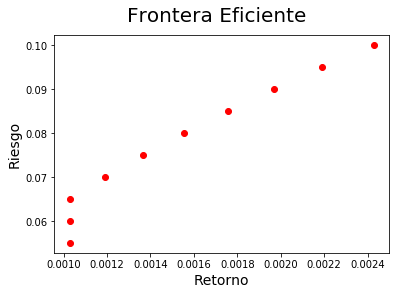

In [130]:
res = [{'type': 'ineq', 'fun': restriccion_1}, {'type': 'ineq', 'fun': restriccion_2}]

graph(solve('COBYLA', res, None, None))

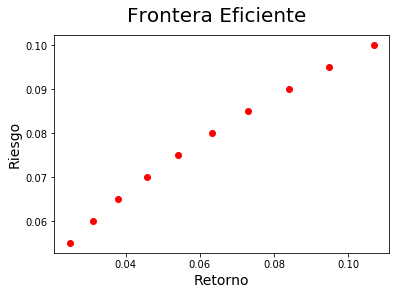

In [133]:
res = [NonlinearConstraint(restriccion_1, 0.05,0.105), NonlinearConstraint(restriccion_2, 0, 0)]

graph(solve('trust-constr', res, gradiente, hessian))